In [2]:
import os
import sys
import pandas as pd
import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize, Lambda
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import logging

In [3]:
import matplotlib.pyplot as plt

In [185]:
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import ImageOps, ImageFilter
from torchvision.transforms import CenterCrop
import cv2
import numpy as np
from torchvision.transforms.functional import center_crop, gaussian_blur


def apply_clahe(image):
    # Assuming the input image is a PIL image, convert it to a numpy array
    image_np = np.array(image)

    # Initialize the CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Assuming the image is grayscale; apply CLAHE
    image_clahe = clahe.apply(image_np)

    # Convert the numpy array back to PIL image
    image_pil = Image.fromarray(image_clahe)
    return image_pil

def high_pass_filter(input_tensor):
    array = input_tensor.numpy().squeeze(0)
    
    # Applying a high-pass filter
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    high_pass_image = cv2.filter2D(array, -1, kernel)
    
    return torch.from_numpy(high_pass_image).unsqueeze(0).float()

def sobel_operator(x):
    # Convert tensor to PIL image
    x = to_pil_image(x)
    # Apply Sobel filter
    x = x.filter(ImageFilter.FIND_EDGES)
    # Convert back to tensor
    return to_tensor(x)

def denoise_image(img):
    # Apply a Gaussian blur for denoising
    return gaussian_blur(img, kernel_size=[5, 5])
    
def custom_center_crop(img):
    return center_crop(img, [1200, 500])


In [171]:
class CustomDataset(Dataset):
    """Custom Dataset class for loading images with labels from CSV file."""
    def __init__(self, csv_file, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.df = pd.read_csv(csv_file)  # Load the entire CSV
        self.df['image_path'] = self.df.apply(lambda row: os.path.join(data_dir, row['scan_name']), axis=1)
        self.df = self.df[self.df['image_path'].apply(os.path.exists)]  # Filter out non-existing files

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path'])#.convert('L')  # Open as grayscale
        if self.transform:
            image = self.transform(image)
        # Convert True/False label to 1/0
        label = 1 if row['status'] == True else 0
        return image, label

In [195]:
def load_data(csv_file, data_dir, batch_size, num_samples=None):
    """Load data using the updated custom dataset generator with CSV filtering."""
    transform = Compose([
        Lambda(custom_center_crop),
        # Lambda(denoise_image),
        Resize((224, 224)),
        Lambda(apply_clahe),
        ToTensor(),
        # Lambda(sobel_operator),
        # Lambda(high_pass_filter),
        Normalize(mean=[0.485], std=[0.229]),  # Normalizing the single channel
        Lambda(lambda x: x.repeat(3, 1, 1))  # Repeating the single channel across to get 3 channels
    ])

    dataset = CustomDataset(csv_file, data_dir, transform)
    # if num_samples:
    #     # If limiting the number of samples, adjust here
    #     dataset = torch.utils.data.Subset(dataset, range(num_samples))
    # loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    # return loader

    return dataset

In [196]:
# Hardcoded configuration parameters
csv_file = '/Users/shubhigupta/Documents/GitHub/OCT-GA-Detection/data/train_dataset_sample.csv'

# Construct the path using the user ID from the environment to ensure it's dynamic and correct
user_id = os.getuid()
# data_dir = f"/run/user/{user_id}/gvfs/smb-share:server=fsmresfiles.fsm.northwestern.edu,share=fsmresfiles/Ophthalmology/Mirza_Images/AMD/dAMD_GA/all_slices_3"

data_dir = "/Volumes/fsmresfiles-1/Ophthalmology/Mirza_Images/AMD/dAMD_GA/all_slices_3"

batch_size = 32

dataset = load_data(csv_file, data_dir, batch_size)

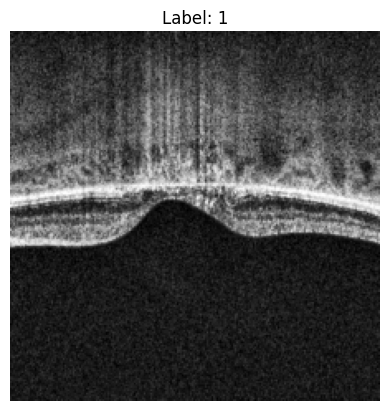

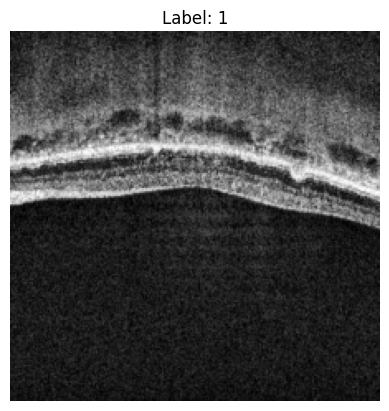

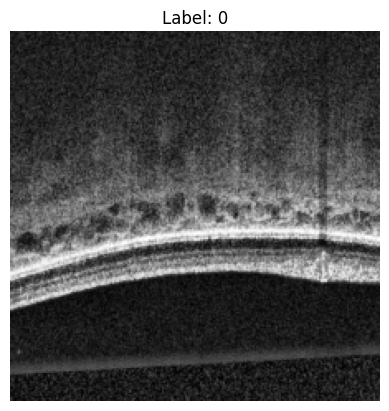

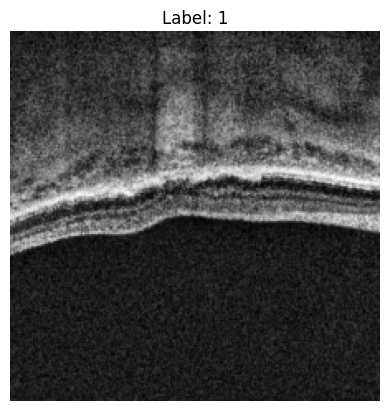

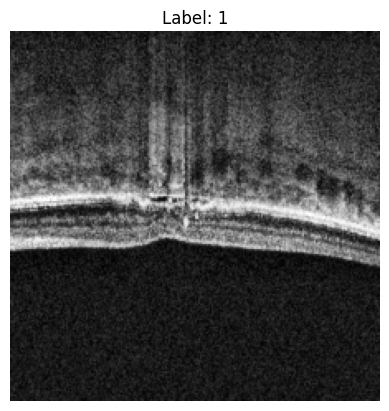

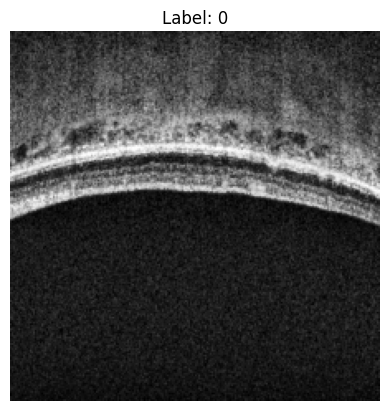

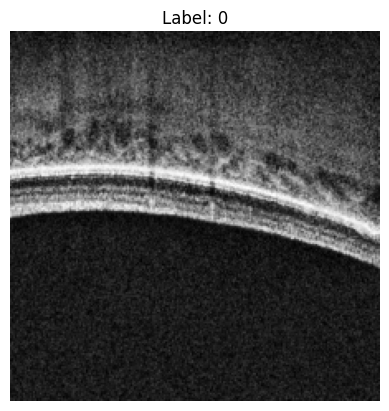

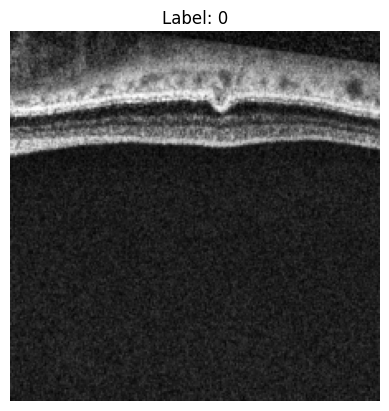

In [197]:
import matplotlib.pyplot as plt

# Load the first image and label from the dataset
for image, label in dataset:

    # Convert the tensor image to a numpy array for plotting
    # Transpose the dimensions from CxHxW to HxWxC
    image = image.numpy().transpose((1, 2, 0))

    # Normalize the image to [0, 1] for correct display
    image = (image - image.min()) / (image.max() - image.min())

    # Display the image
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.axis('off')  # Hide axes
    plt.show()

In [74]:
len(dataset)

8

In [22]:
import pandas as pd

input_file_path = '/Users/shubhigupta/Documents/GitHub/OCT-GA-Detection/data/train_dataset.csv'
output_file_path = '/Users/shubhigupta/Documents/GitHub/OCT-GA-Detection/data/train_dataset_sample.csv'

# Read the first 10 rows of the CSV file
df = pd.read_csv(input_file_path, nrows=10)

# Save the extracted rows into a new CSV file
df.to_csv(output_file_path, index=False)